In [1]:
import torch
import torch.nn.functional as f
import math
from torch.utils.data import Dataset, DataLoader
import tiktoken

In [2]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, dim_model, num_heads, bias, model_dropout):
        super().__init__()
        self.dim_model = dim_model
        self.bias = bias
        self.num_heads = num_heads
        self.head_dim = dim_model // num_heads
        self.weights_query = torch.nn.Linear(self.dim_model, self.dim_model, bias=self.bias)
        self.weights_value = torch.nn.Linear(self.dim_model, self.dim_model, bias=self.bias)
        self.weights_key = torch.nn.Linear(self.dim_model, self.dim_model, bias=self.bias)
        self.dropout = torch.nn.Dropout(model_dropout)
    def forward(self,inputs):
        query = self.weights_query(inputs)
        key = self.weights_key(inputs)
        value = self.weights_value(inputs)
        query =  torch.reshape(query,(inputs.shape[0], inputs.shape[1], self.num_heads,self.head_dim))
        key =  torch.reshape(key,(inputs.shape[0], inputs.shape[1], self.num_heads,self.head_dim))
        value = torch.reshape(value,(inputs.shape[0], inputs.shape[1], self.num_heads,self.head_dim))
        query = query.transpose(1,2)
        key = key.transpose(1,2)
        value = value.transpose(1,2)
        multi_head_attention_scores = torch.matmul(query, key.transpose(2,3))
        mask = torch.triu(torch.ones(multi_head_attention_scores.shape),diagonal=1) ==1
        result =  multi_head_attention_scores.masked_fill(mask==True, -torch.inf)
        multi_head_attn_weights = torch.softmax(result / key.shape[-1]**0.5, dim=-1)
        dropout = torch.nn.Dropout(0.5)
        multi_head_attn_weights = dropout(multi_head_attn_weights)
        multi_head_context_vectors = torch.matmul(multi_head_attn_weights,value).transpose(1,2)
        multi_head_context_vectors = torch.reshape(multi_head_context_vectors,(inputs.shape[0],inputs.shape[1],self.dim_model))
        return multi_head_context_vectors

In [3]:
class layer_normalisation(torch.nn.Module):
    def __init__(self, dim_model):
        super().__init__()
        self.scale = torch.nn.Parameter(torch.ones(dim_model))
        self.shift = torch.nn.Parameter(torch.zeros(dim_model))
        self.eps = 1e-5
    def forward(self, inputs):
        mean = inputs.mean( dim =-1, keepdim=True)
        var = inputs.var( dim =-1, keepdim=True)
        normalized_inputs = (inputs - mean) / torch.sqrt(var + self.eps)
        normalized_inputs = self.scale * normalized_inputs + self.shift
        return normalized_inputs

In [4]:
class GeLU(torch.nn.Module):
    def __init__(self):
     super().__init__()

    def forward(self, inputs):
       return 0.5 * inputs * (1 + torch.tanh(torch.sqrt(torch.tensor(2 / math.pi)) * (inputs + 0.044715 * torch.pow(inputs, 3))))

In [5]:
class feed_forward(torch.nn.Module):
    def __init__(self,dim_model):
        super().__init__()
        self.layer = torch.nn.Sequential(torch.nn.Linear(dim_model,4*dim_model),GeLU(),
                                         torch.nn.Linear(4*dim_model,dim_model))
    def forward(self, inputs):
        return self.layer(inputs)

In [6]:
class Transformer(torch.nn.Module):
    def __init__(self, dim_model, num_heads, model_dropout):
        super().__init__()
        self.layer_norm = layer_normalisation(dim_model)
        self.layer_norm2 = layer_normalisation(dim_model)
        self.attention = MultiHeadAttention(dim_model, num_heads, False, model_dropout)
        self.feed_forward = feed_forward(dim_model)
        self.dropout = torch.nn.Dropout(model_dropout)
    def forward(self, inputs):
        shortcut_connection = inputs
        layer_norm_output = self.layer_norm(inputs)
        attention_output = self.attention(layer_norm_output)
        attention_output = self.dropout(attention_output)
        attention_output += shortcut_connection
        shortcut_connection = attention_output
        layer_norm_output2 = self.layer_norm2(attention_output)
        feed_forward_output = self.feed_forward(layer_norm_output2)
        feed_forward_output = self.dropout(feed_forward_output)
        feed_forward_output += shortcut_connection
        return feed_forward_output


In [7]:
class gpt2_architecture(torch.nn.Module):
    def __init__(self,config):
        super().__init__()
        self.token_embedding = torch.nn.Embedding(config["vocab_size"],config["emb_dim"])
        self.positional_embedding = torch.nn.Embedding(config['context_length'],config["emb_dim"])
        self.dropout = torch.nn.Dropout(config['drop_rate'])
        self.transformer = torch.nn.Sequential(*[Transformer(config['emb_dim'],config['n_heads'],config['drop_rate']) for i in range(config['n_layers'])])
        self.final_layer_norm = layer_normalisation(config['emb_dim'])
        self.output_layer = torch.nn.Linear(config["emb_dim"],config["vocab_size"])
    
    def forward(self, inputs):
        x = self.token_embedding(inputs)
        x = x + self.positional_embedding(torch.arange(inputs.shape[-1]))
        x = self.dropout(x)
        x = self.transformer(x)
        x = self.final_layer_norm(x)
        x = self.output_layer(x)
        return x


In [8]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

In [9]:
class SimpleDataset(Dataset):
    def __init__(self, data, stride, context_length):
        self.input =[]
        self.output =[]
        enc_text = data
        for i in range(0,len(enc_text)-context_length, stride):
            self.input.append(enc_text[i:i+context_length])
            self.output.append(enc_text[i+1:i+1+context_length])
    def __len__(self):
        return len(self.input)
    def __getitem__(self,index):
        return torch.tensor(self.input)[index], torch.tensor(self.output)[index]

In [10]:
def create_dataloader(data, context_length=256, stride=128,shuffle= False,batch_size=4,num_workers=0,drop_last=True):
    dataset = SimpleDataset(data, stride, context_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,num_workers=num_workers,drop_last=drop_last)
    return dataloader

As discussed in the full_gpt_architecture file we will be using a manual split as it is simple and we are building this to know how to build one.

In [11]:
import re
filename = 'the-verdict.txt'
with open(filename,'r') as f:
    data = f.read()
print("The total length of the filename is:", len(data))

The total length of the filename is: 20479


In [12]:
# Train/validation ratio
tokenizer = tiktoken.get_encoding("gpt2")
encoded_text = tokenizer.encode(data)
train_ratio = 0.90
split_idx = int(train_ratio * len(encoded_text))
train_data = encoded_text[:split_idx]
val_data = encoded_text[split_idx:]
tokenizer.decode(train_data[:5])

'I HAD always thought'

In [13]:
torch.manual_seed(123)

train_loader = create_dataloader(
    train_data,
    batch_size=2,
    context_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader(
    val_data,
    batch_size=2,
    context_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [14]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

print(len(train_loader))
print(len(val_loader))

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])
9
1


we implement a utility function to calculate the cross-entropy loss of a given batch.

In [15]:
def cross_entropy_loss_batch(model,inputs, actual_output):
    predicted_output = model(inputs)
    loss = torch.nn.functional.cross_entropy(predicted_output.flatten(0,1),actual_output.flatten(0,1))
    return loss

def cross_entropy_loss_loader(model, dataloader):
    total_loss =0
    for inputs, actual_output in dataloader:
        total_loss += cross_entropy_loss_batch(model,inputs,actual_output)
    return total_loss/len(dataloader)



In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(123)
model = gpt2_architecture(GPT_CONFIG_124M)

model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes
model.eval()

torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = cross_entropy_loss_loader(model,train_loader)
    val_loss = cross_entropy_loss_loader(model,val_loader)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

cpu
Training loss: tensor(10.9648)
Validation loss: tensor(10.9826)


In [17]:
def generate_new_tokens(model, inputs, expected_context_length):
    model.eval()
    for i in range(expected_context_length):
        with torch.no_grad():
            out = model(inputs)
        indexes = torch.argmax(out[:,-1,:],keepdim=True,dim=1)
        inputs = torch.cat((inputs,indexes),dim=1)
    return inputs

In [18]:
tokenizer = tiktoken.get_encoding("gpt2")
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"



token_ids = generate_new_tokens(
    model=model,
    inputs=text_to_token_ids(start_context, tokenizer),expected_context_length=10)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you ib monstrousters Aluminum helpedovo 1280mL appBuyable


In [ ]:
def train_gpt(model,train_loader,val_loader,num_epoch,optimizer,eval_freq,start_context,tokenizer):
    train_losses, val_losses = [],[]
    global_step = -1
    for i in range(num_epoch):
        model.train()
        for inputs,actual_outputs in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = cross_entropy_loss_batch(model,inputs, actual_outputs)
            loss.backward() # Calculate loss gradients
            optimizer.step()
            global_step+=1

            if global_step % eval_freq == 0:
                model.eval()
                with torch.no_grad():
                    train_loss = cross_entropy_loss_loader(model,train_loader)
                    val_loss = cross_entropy_loss_loader(model,val_loader)
                    print(f"Ep {i+1} (Step {global_step:06d}): "
                        f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                model.train()
        token_ids = generate_new_tokens(
        model=model,
        inputs=text_to_token_ids(start_context, tokenizer),expected_context_length=10)
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))  # Compact print format
        model.train()
    return train_losses,val_losses



In [20]:
torch.manual_seed(123)
model = gpt2_architecture(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
start_context = "Every effort moves you"
num_epoch = 10

train_losses, val_losses, = train_gpt(model,train_loader,val_loader,num_epoch,optimizer,eval_freq=5,start_context=start_context,tokenizer=tokenizer)


Ep 1 (Step 000000): Train loss 9.929, Val loss 10.005
Ep 1 (Step 000005): Train loss 8.128, Val loss 8.382
Ep 2 (Step 000010): Train loss 6.739, Val loss 7.071
Ep 2 (Step 000015): Train loss 6.092, Val loss 6.578
Ep 3 (Step 000020): Train loss 5.778, Val loss 6.496
Ep 3 (Step 000025): Train loss 5.661, Val loss 6.512
Ep 4 (Step 000030): Train loss 5.513, Val loss 6.490
Ep 4 (Step 000035): Train loss 5.160, Val loss 6.424
Ep 5 (Step 000040): Train loss 4.813, Val loss 6.414
Ep 6 (Step 000045): Train loss 4.311, Val loss 6.340
Ep 6 (Step 000050): Train loss 3.782, Val loss 6.294
Ep 7 (Step 000055): Train loss 3.311, Val loss 6.237
Ep 7 (Step 000060): Train loss 2.864, Val loss 6.135
Ep 8 (Step 000065): Train loss 2.397, Val loss 6.197
Ep 8 (Step 000070): Train loss 1.979, Val loss 6.168
Ep 9 (Step 000075): Train loss 1.581, Val loss 6.258
Ep 9 (Step 000080): Train loss 1.240, Val loss 6.291
Ep 10 (Step 000085): Train loss 0.958, Val loss 6.418
Every effort moves you?"  "Yes--quite insens

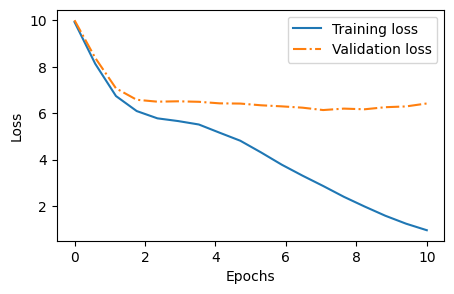

In [21]:
# Plot the results
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
epochs_tensor = torch.linspace(0, num_epoch, len(train_losses))
fig, ax1 = plt.subplots(figsize=(5, 3))
# Plot training and validation loss against epochs
ax1.plot(epochs_tensor, train_losses, label="Training loss")
ax1.plot(epochs_tensor, val_losses, linestyle="-.", label="Validation loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper right")
ax1.xaxis.set_major_locator(MaxNLocator(integer=True)) 


In [22]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, 'checkpoint.pth')